In [ ]:
# install libraries
!pip install datasets transformers
!pip install datasets[vision]
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.2 MB/s eta 0:00:00
Looking in index

In [ ]:
# mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import os
import pandas as pd
import joblib
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from IPython.display import display
from sklearn import model_selection, metrics
from transformers import ViTForImageClassification, ViTImageProcessor, ResNetForImageClassification, AutoImageProcessor, SwinForImageClassification
from torch.utils.data import DataLoader

In [ ]:
# set seed for reproducible results
def seed_everything(seed):

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [ ]:
# set global variables
IMG_SIZE = 224
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# read csv data with image information and labels
df = pd.read_csv("sat_data_key.csv")
df.rename(columns={"pm2.5_scale": "label"}, inplace=True)
df["label"] = df["label"] - 1
print(len(df))

1900


<Axes: xlabel='label'>

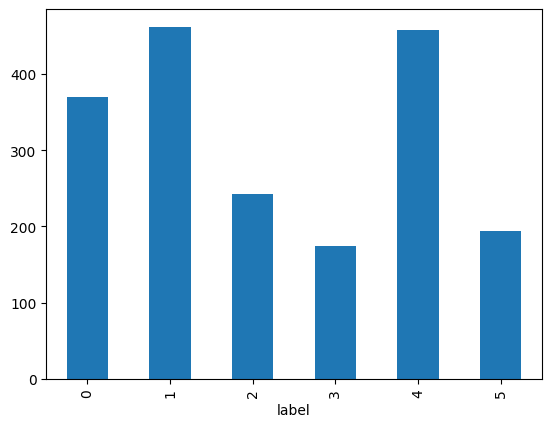

In [ ]:
# histogram of data for each label/category
df.groupby(['label']).size().plot.bar()

In [ ]:
df_3 = df[df["label"]==3]
df_5 = df[df["label"]==5]

df = df.append(df_3, ignore_index = True)
df = df.append(df_5, ignore_index = True)

df["img_path"] = "/content/drive/MyDrive/air_training_data/" + df["img_num"].astype("str")

df = df[df["dist_to_monitor"] <= 0.2]

<ipython-input-8-139bd04e7a70>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3, ignore_index = True)
<ipython-input-8-139bd04e7a70>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_5, ignore_index = True)


<Axes: xlabel='label'>

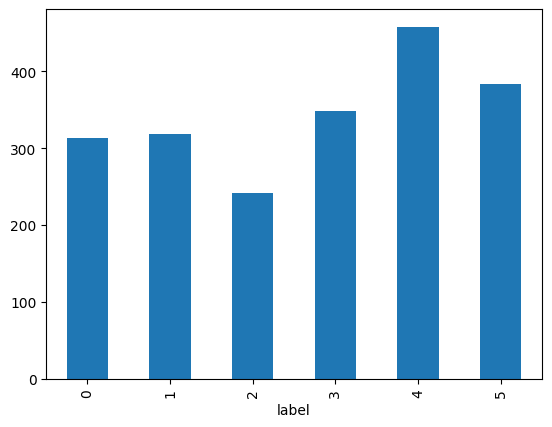

In [ ]:
df.groupby(['label']).size().plot.bar()

In [ ]:
print(len(df))

2064


In [ ]:
# split data for training and validation
df_train, df_val = model_selection.train_test_split(
    df, test_size=0.1, random_state=10, stratify=df.label.values
)

In [ ]:
# set paths for each image
train_paths = df_train["img_path"].to_list()
train_labels = df_train["label"].to_list()

test_paths = df_val["img_path"].to_list()
test_labels = df_val["label"].to_list()

In [ ]:
# write custom data set class
class GeoDataset():
  def __init__(self, paths, labels, transforms=None):
    self.ids = range(1,len(paths))
    self.paths = paths
    self.labels = labels
    self.transforms = transforms
    self.pixel_values = None

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, key):

    item = {
        "id": self.ids[key],
        "img": Image.open(self.paths[key]),
        "label": self.labels[key],
        "pixel_values": self.pixel_values[key]
    }
    return item

  def set_transforms(self):
    if self.transforms == None:
      return

    self.pixel_values = torch.zeros(len(self.ids), 3, IMG_SIZE, IMG_SIZE)
    for i in range(len(self.ids)):
      img = Image.open(self.paths[i]).convert("RGB")
      self.pixel_values[i] = self.transforms(img)

In [ ]:
# since the indices are not zero indexed, we maintain this key
id2label = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 5
}

label2id = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 5,
}

ViT training

In [ ]:
# load vit processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [ ]:
# perform transformations on training and validation images
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

In [ ]:
# convert training and testing images into geodataset class objects
train_ds = GeoDataset(train_paths, train_labels, train_transforms)
test_ds = GeoDataset(test_paths, test_labels, val_transforms)

In [ ]:
# apply transforms to both datasets
train_ds.set_transforms()
test_ds.set_transforms()

In [ ]:
# sample image after tokenizing
train_ds[2]

{'id': 3,
 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1192x1194 at 0x7F75CAB5D4E0>,
 'label': 5,
 'pixel_values': tensor([[[-0.2314, -0.2235, -0.1843,  ..., -0.0510, -0.1608, -0.1686],
          [-0.2078, -0.0745, -0.1686,  ..., -0.0275, -0.2078, -0.2000],
          [-0.2863, -0.2235, -0.2627,  ..., -0.1294, -0.1451, -0.2549],
          ...,
          [-0.3412, -0.3098, -0.2157,  ..., -0.0353, -0.0745, -0.2078],
          [-0.3647, -0.2784, -0.3725,  ..., -0.0588, -0.1451, -0.2471],
          [-0.2706, -0.2392, -0.2627,  ..., -0.1294, -0.1529, -0.2000]],
 
         [[-0.1294, -0.1216, -0.0824,  ...,  0.0196, -0.0902, -0.0980],
          [-0.1059,  0.0196, -0.0745,  ...,  0.0588, -0.1216, -0.1137],
          [-0.1922, -0.1294, -0.1686,  ..., -0.0431, -0.0510, -0.1608],
          ...,
          [-0.2314, -0.2000, -0.1059,  ...,  0.0588,  0.0196, -0.1137],
          [-0.2549, -0.1686, -0.2627,  ...,  0.0353, -0.0510, -0.1529],
          [-0.1608, -0.1294, -0.1529,  ..., 

In [ ]:
# converting images into pixel values and collating with labels
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id,
                                                  num_labels=6)

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(torch.version.cuda)

model.to("cuda")

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"sat_data_output",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy= metrics.accuracy_score(predictions, labels))

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.675085,0.825243
2,No log,0.464465,0.919094
3,0.577700,0.401908,0.919094


TrainOutput(global_step=525, training_loss=0.5650909787132626, metrics={'train_runtime': 333.5096, 'train_samples_per_second': 25.052, 'train_steps_per_second': 1.574, 'total_flos': 6.474687846294528e+17, 'train_loss': 0.5650909787132626, 'epoch': 3.0})

In [ ]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.4644654393196106, 'test_accuracy': 0.919093851132686, 'test_runtime': 4.0933, 'test_samples_per_second': 75.489, 'test_steps_per_second': 9.528}


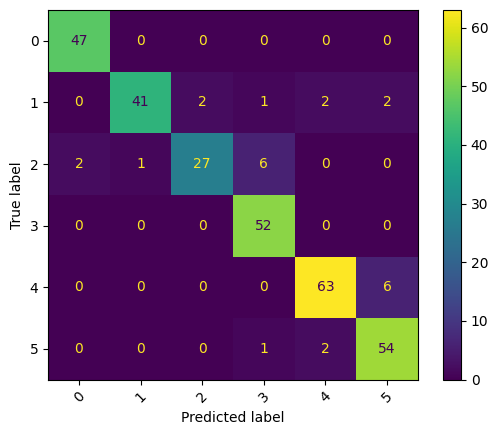

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = [0,1,2,3,4,5]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
mismatches = []
for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    mismatches.append(i)

In [ ]:
print(mismatches)

[6, 9, 13, 14, 24, 34, 38, 40, 63, 67, 69, 73, 81, 85, 94, 100, 101, 102, 113, 127, 156, 161, 164, 192, 206, 219, 225, 233, 235, 239, 249, 251, 264, 269, 283]


ResNet

In [ ]:
resnet_model = ResNetForImageClassification.from_pretrained(model_name="microsoft/resnet-50",
                                                            id2label=id2label,
                                                            label2id=label2id,
                                                            labels=6)
resnet_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
metric_name = "accuracy"

resnet_args = TrainingArguments(
    f"sat_data_output",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.000001,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy= metrics.accuracy_score(predictions, labels))

In [ ]:
resnet_trainer = Trainer(
    model=resnet_model,
    args=resnet_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=resnet_processor,
)

In [ ]:
resnet_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.710073,0.792880
2,No log,0.823075,0.741100
3,No log,0.466729,0.864078
4,No log,0.338919,0.912621
5,No log,0.266957,0.938511


TrainOutput(global_step=440, training_loss=0.1706175370649858, metrics={'train_runtime': 187.3463, 'train_samples_per_second': 74.328, 'train_steps_per_second': 2.349, 'total_flos': 3.214209366724608e+17, 'train_loss': 0.1706175370649858, 'epoch': 5.0})

In [ ]:
outputs = resnet_trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.26695704460144043, 'test_accuracy': 0.9385113268608414, 'test_runtime': 1.4327, 'test_samples_per_second': 215.67, 'test_steps_per_second': 13.959}


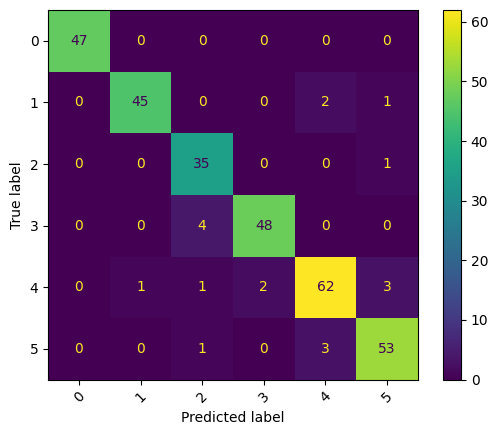

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = [0,1,2,3,4,5]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

Swin Transformer

In [ ]:
swin_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swin_model = SwinForImageClassification.from_pretrained(
    'microsoft/swin-base-patch4-window7-224',
    num_labels=6,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True,
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([6, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric_name = "accuracy"

swin_args = TrainingArguments(
    f"swin_data_output",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    logging_steps=10,
    warmup_ratio=0.1,
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=4,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy= metrics.accuracy_score(predictions, labels))

In [ ]:
swin_trainer = Trainer(
    model=swin_model,
    args=swin_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=swin_processor,
)

In [ ]:
swin_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.304700,0.463024,0.831715
1,0.221800,0.371058,0.864078
2,0.124300,0.263983,0.906149


TrainOutput(global_step=129, training_loss=0.22098718317904215, metrics={'train_runtime': 324.5744, 'train_samples_per_second': 25.741, 'train_steps_per_second': 0.397, 'total_flos': 6.4450100138206e+17, 'train_loss': 0.22098718317904215, 'epoch': 2.95})

In [ ]:
outputs = swin_trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.26398321986198425, 'test_accuracy': 0.9061488673139159, 'test_runtime': 4.3891, 'test_samples_per_second': 70.402, 'test_steps_per_second': 8.886}


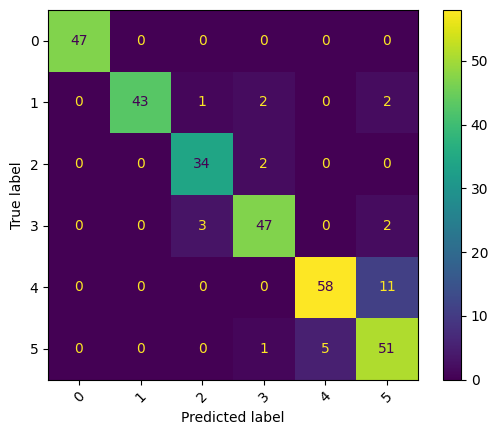

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = [0,1,2,3,4,5]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)